In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.distributions import Uniform
from torchvision import datasets as dsets
from torchvision import transforms as T
from torchvision.utils import make_grid

In [4]:
cifar10 = dsets.CIFAR10(
    root="dataset",
    download=True,
    train=True,
    transform=T.Compose([
        T.CenterCrop((32, 32)),
        T.ToTensor()
    ])
)

Extracting dataset/cifar-10-python.tar.gz to dataset


In [48]:
loader = DataLoader(
    cifar10,
    batch_size=25,
    shuffle=True
)

In [49]:
def plot_tensor(tensor):
    r"""
    tensor (Tensor): the image tensor of shape (N, C, H, W) 
    """
    grid_tensor = make_grid(tensor, nrow=5, padding=2)
    plt.figure(figsize=(15, 12))
    plt.imshow(grid_tensor.permute(1, 2, 0).numpy())
    plt.show()

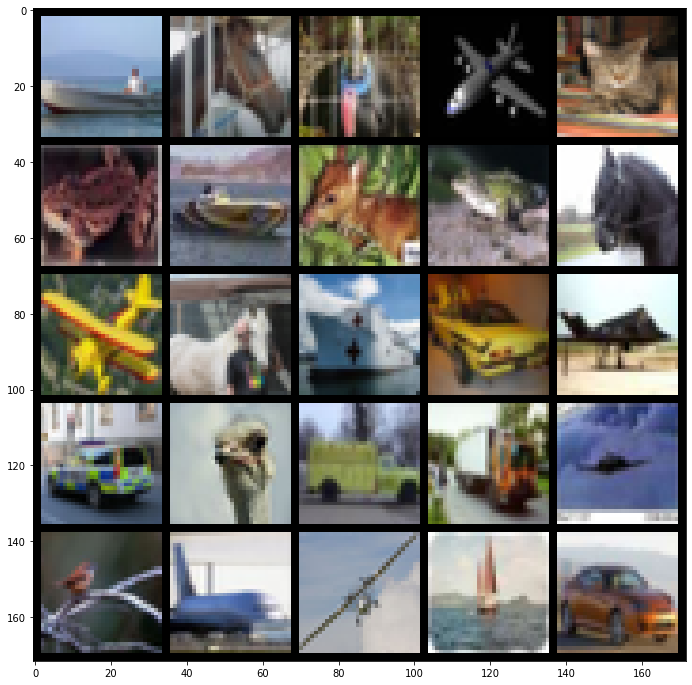

In [50]:
plot_tensor(next(iter(loader))[0])

In [51]:
class CutMix:

    def __init__(self, beta=1., prob=0.5, warmup=50000):
        self.beta = beta
        self.prob = prob
        self.warmup = warmup
        self.increment = self._get_prob_increment()

    def _get_prob_increment(self):

        increment = 0
        if self.warmup is not None:
            increment = 0.5 / self.warmup

        return increment

    def _get_current_prob(self, iteration):

        current_prob = iteration * self.increment
        prob = np.minimum(current_prob, 0.5)

        return prob

    def _get_batch_random_prob(self, shape, same_on_batch=False):

        dist = Uniform(low=0., high=1.)
        if same_on_batch:
            return dist.rsample((1, )).repeat(shape[0])
        else:
            return dist.rsample((shape[0], ))

    def __call__(self, real_images, fake_images, iteration):

        image_shape = real_images.shape

        batch_prob = self._get_batch_random_prob(real_images.shape, same_on_batch=False)
        batch_prob = (batch_prob < self._get_current_prob(iteration))

        # generate mixed sample
        lam = np.random.beta(self.beta, self.beta)
        bbx1, bby1, bbx2, bby2 = rand_bbox(image_shape, lam)
        real_images[batch_prob, :, bbx1:bbx2, bby1:bby2] = \
            fake_images[batch_prob, :, bbx1:bbx2, bby1:bby2]
        mask = get_binary_mask(image_shape, bbx1, bby1, bbx2, bby2, batch_prob)
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_shape[-1] * image_shape[-2]))
        return real_images, fake_images, lam, mask


def get_binary_mask(size, bbx1, bby1, bbx2, bby2, batch_prob):

    N, _, H, W = size
    mask = torch.ones((N, 1, H, W))
    mask[batch_prob, :, bbx1:bbx2, bby1:bby2] = 0

    return mask


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [60]:
cutmix_aug = CutMix(beta=1., prob=0.5, warmup=1)

In [61]:
data_iterator = iter(loader)
sample_1, _ = next(data_iterator)
sample_2, _ = next(data_iterator)

In [62]:
cutmix_images, _, lam, mask = cutmix_aug(sample_1, sample_2, iteration=1)

print(cutmix_images.shape)

torch.Size([25, 3, 32, 32])


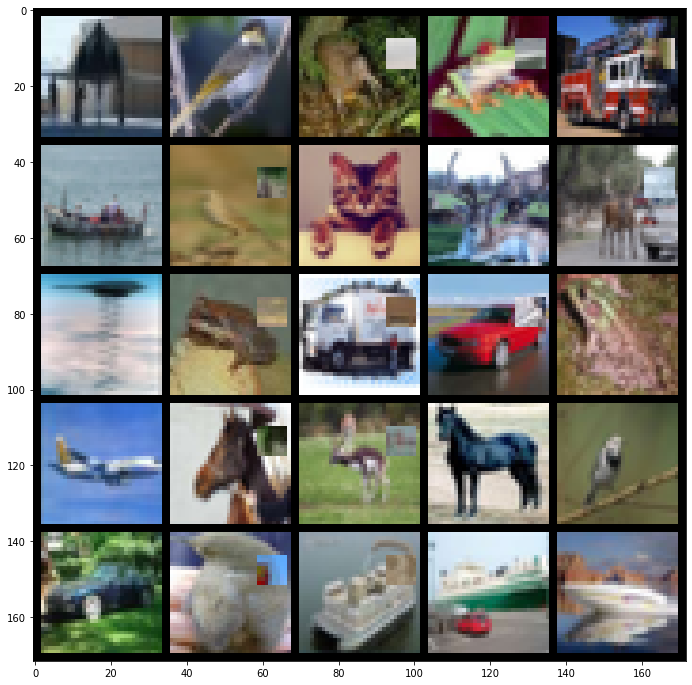

In [63]:
plot_tensor(cutmix_images)